# Wide Baseline Matching

Как всегда подключаем библиотеки.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
                                 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 16)

Определяем вспомогательные функции.

In [2]:
def show_keypoints(img, kps):
    kps_img = cv2.drawKeypoints(
        img,
        kps,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    plt.imshow(kps_img)
    
    
def show_matches(img1, kps1, img2, kps2, matches):
    params = dict(
        flags=(cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS |
               cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS),
        outImg=None
    )
    if isinstance(matches[0], cv2.DMatch):
        plt.imshow(cv2.drawMatches(img1, kps1, img2, kps2, matches, **params))
    else:
        plt.imshow(cv2.drawMatchesKnn(img1, kps1, img2, kps2, matches, **params))

## Сопоставление двух изображений

Считаем изображения.

In [3]:
img1 = cv2.imread('./data/prague_1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./data/prague_2.jpg', cv2.IMREAD_GRAYSCALE)

Посмотрим на них. Обратите внимание на отличия в освещении и существенно разные точки съемки.

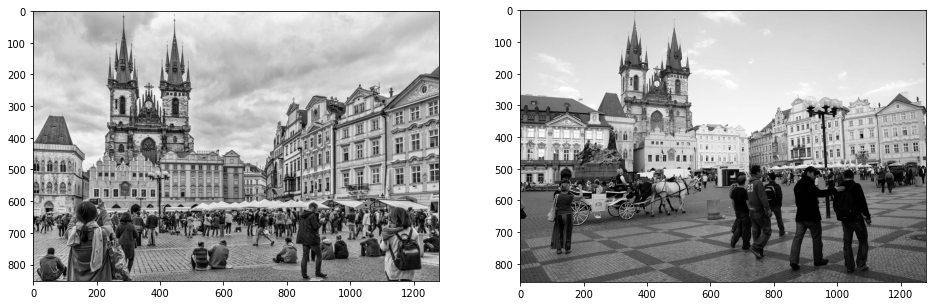

In [4]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img1, cmap='gray', vmin=0, vmax=255)
ax2.imshow(img2, cmap='gray', vmin=0, vmax=255)

### 1. Детектирование точечных особенностей

Создадим специальный объект для детектирования ключевых точек и подсчета дескрипторов SIFT. Можете попробовать поменять параметры и посмотреть, как это повлияет на дальнейшие шаги.

In [5]:
sift = cv2.SIFT_create()

С помощью `sift.detect` найдите ключевые точки на первом изображении.

In [6]:
kps1 = None  # TODO
print(len(kps1))
show_keypoints(img1, kps1)

### 2. Подсчет дескрипторов

С помощью `sift.compute` посчитайте дескрипторы для найденных ключевых точек.

In [7]:
_, ds1 = None, None  # TODO
print(ds1.shape, ds1.dtype)
print(ds1)

С помощью `sift.detectAndCompute` посчитайте ключевые точки и дескрипторы для второго изображения.

In [8]:
kps2, ds2 = None, None  # TODO
print(len(kps2))
show_keypoints(img2, kps2)

### 3. Матчинг дескрипторов

Для того, чтобы не писать поиск ближайших соседей руками, в OpenCV существуют уже готовые реализации. Мы будем использовать поиск полным перебором.

In [9]:
matcher = cv2.BFMatcher_create(
    cv2.NORM_L2,  # Для дескрипторов SIFT нужна метрика L2.
    False         # Cross check пока что выключим. Если хотите, попробуйте потом включить.
)

Попробуем запустить матчер.

In [10]:
matches_1_to_2 = matcher.knnMatch(ds1, ds2, 1)
print(len(matches_1_to_2))
show_matches(img1, kps1, img2, kps2, matches_1_to_2)

Как вы видите, соответствий очень много и среди них явно много мусора.

С помощью какой-нибудь стратегии матчинга постройте `tentatives` — список предварительных соотвествий.

In [11]:
tentatives = None  # TODO

Посмотрите, сколько их получилось, стало ли лучше на вид.

In [12]:
print(len(tentatives))
show_matches(img1, kps1, img2, kps2, tentatives)

### 4. Геометрическая верификация

Зададим настройки для геометрической верификации. Будем пробовать два варианта библиотек, для сравнения важно будет задать одинаковые параметры.

In [13]:
CONFIDENCE = 0.999
MAX_ITERS = 10 ** 4
THRESHOLD_PX = 1.0

С помощью `cv2.findFundamentalMat` с параметров `method=cv2.RANSAC` проведите геометрическую верификацию предварительных соответствий и постройте список итоговых соответствий `verified_fm`.

In [14]:
params_opencv = dict(
    method=cv2.RANSAC,
    ransacReprojThreshold=THRESHOLD_PX,
    confidence=CONFIDENCE,
    maxIters=MAX_ITERS
)

In [15]:
verified_fm = None  # TODO

Посмотрим, сколько соответствий осталось и как они выглядят.

In [16]:
print(len(verified_fm))
show_matches(img1, kps1, img2, kps2, verified_fm)

### 5. Поиск гомографии

С помощью `cv2.findFundamentalMat` с параметров `method=cv2.RANSAC` попробуйте найти гомографию между двумя этими изображениями и постройте список итоговых соответствий `verified_hm`.

In [17]:
verified_hm = None  # TODO

Какие части изображений связаны найденной гомографией? Почему?

In [18]:
print(len(verified_hm))
show_matches(img1, kps1, img2, kps2, verified_hm)

### 6. pydegensac

Проделайте поиск фундаментальной матрицы и гомографии с помощью `pydegensac.findFundamentalMatrix` и `pydegensac.findHomography`. Не забудьте задать те же параметры, что использовались в OpenCV.

Если же `pydegensac` не устанавливается, вероятно, у вас версия OpenCV $\geqslant$ 4.5. В такой ситуации прямо в функции OpenCV вместо `cv2.RANSAC` можно передавать не указанные в документации параметры с префиксом `cv2.USAC_`. Эти параметры позволяют запускать более продвинутые модификации RANSAC. Попробуйте разные методы и сравните результаты.

In [19]:
import pydegensac

params_pydegensac = dict(
    px_th=THRESHOLD_PX,
    conf=CONFIDENCE,
    max_iters=MAX_ITERS
)

In [20]:
verified_fm_pd = None  # TODO
verified_hm_pd = None  # TODO

Стало ли лучше?

In [21]:
print(len(verified_fm_pd))
show_matches(img1, kps1, img2, kps2, verified_fm_pd)

In [22]:
print(len(verified_hm_pd))
show_matches(img1, kps1, img2, kps2, verified_hm_pd)

## Детектирование плоского объекта

### 7. Детектирование книги по обложке

Считаем изображения книги и ее обложки.

In [23]:
book = cv2.imread('./data/book.jpg', cv2.IMREAD_GRAYSCALE)
cover = cv2.imread('./data/book_cover.jpg', cv2.IMREAD_GRAYSCALE)

In [24]:
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cover, cmap='gray', vmin=0, vmax=255)
ax2.imshow(book, cmap='gray', vmin=0, vmax=255)

С помощью ключевых точек найдите обложку на фотографии книги и обведите ее рамкой примерно как на следующем примере:

![](./fig/book_found.png)

Помимо того, что мы уже сегодня использовали, вам пригодятся функции `cv2.perspectiveTransform`, `cv2.polylines` и `cv2.cvtColor`.

In [25]:
ch, cw = cover.shape
cover_corners = np.float32([
    [0, 0],
    [0, ch - 1],
    [cw - 1, ch - 1],
    [cw - 1, 0]
]).reshape(-1, 1, 2)

book_corners = None  # TODO

book_rgb = cv2.cvtColor(book, cv2.COLOR_GRAY2RGB)
# cv2.polylines(book_rgb, [book_corners], True, (0, 0, 255), 3, cv2.LINE_AA)
# plt.imshow(book_rgb)